## Carga y  prepación de el dataframe

Cargamos y preparamos el dataframe teniendo en cuenta el analisis y la evaluación efectuada. Y de esta manera comenzar a evaluar los distintos modelos y cómo estos se comportan frente a los datos.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = 25, 10

In [2]:
full = pd.read_csv('data/reproductions.csv')

full['age'] = datetime.now().date().year - full['birth_year']

full.loc[full['body_development'].isnull(),'body_development'] = 0

full.loc[full['DIB_placement'].notnull(),'DIB_placement_converted'] = 1
full.loc[full['DIB_placement'].isnull(),'DIB_placement_converted'] = 0

full.loc[full['DIB_extraction'].notnull(),'transformed_DIB_extraction'] = 1
full.loc[full['DIB_extraction'].isnull(),'transformed_DIB_extraction'] = 0

full.loc[full.reproduction_type == 'Natural','reproduction_type'] = 1
full.loc[full.reproduction_type == 'Inseminacion','reproduction_type'] = 0

full.loc[full.palpation_after == 'Preñada','palpation_after'] = 1
full.loc[full.palpation_after == 'preñada','palpation_after'] = 1
full.loc[full.palpation_after == 'Vacia','palpation_after'] = 0
full.loc[full.palpation_after == 'No Paso','palpation_after'] = 0
full.loc[full.palpation_after == 'Sin Tacto','palpation_after'] = 0
full.loc[full.palpation_after == 'vacia','palpation_after'] = 0

full['body_development'] = full['body_development'].round()

full.loc[full['reproduction_released'].notnull(),'transformed_reproduction_released'] = 1
full.loc[full['reproduction_released'].isnull(),'transformed_reproduction_released'] = 0

full['success_reproduction_count'] = full['success_insemination_count'] + full['success_natural_count']
full['fail_reproduction_count'] = full['fail_insemination_count'] + full['fail_natural_count']

full['pregnant_after_count'] = full['pregnant_after_insemination_count'] + full['pregnant_after_natural_count']
full['empty_after_count'] = full['empty_after_natural_count'] + full['empty_after_insemination_count']

full['reproduction_execution'] = pd.to_datetime(full.reproduction_execution)
full['date_offset'] = (pd.DatetimeIndex(full.reproduction_execution).month*100 + pd.DatetimeIndex(full.reproduction_execution).day - 320)%1300
full['season'] = pd.cut(full['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['autumn', 'winter', 'spring', 'summer'])

full.drop(full.loc[full['reproduction_type'].isnull()].index, inplace=True)
full.drop(full.loc[full['season'].isnull()].index, inplace=True)

del full['palpation_before']
del full['birth_year']
del full['brood_sex']
del full['CUT_before']
del full['CUT_after']
del full['DIB_placement']
del full['DIB_extraction']
del full['reproduction_released']

full.head() 

,ID,flock_number,body_development,reproduction_type,reproduction_execution,palpation_after,DIB_placement_count,DIB_extraction_count,success_insemination_count,fail_insemination_count,...,age,DIB_placement_converted,transformed_DIB_extraction,transformed_reproduction_released,success_reproduction_count,fail_reproduction_count,pregnant_after_count,empty_after_count,date_offset,season
0,1,5,0.0,1,2014-01-09,1,0,0,0,0,...,11,0.0,0.0,1.0,0,0,0,0,1089.0,summer
1,2,9,0.0,0,2014-12-20,1,0,0,0,0,...,11,1.0,1.0,1.0,0,0,0,0,900.0,spring
2,3,35,0.0,1,2014-01-09,1,0,0,0,0,...,11,0.0,0.0,1.0,0,0,0,0,1089.0,summer
3,4,38,0.0,0,2014-12-20,1,0,0,0,0,...,11,1.0,1.0,1.0,0,0,0,0,900.0,spring
4,5,49,0.0,0,2014-12-20,1,0,0,0,0,...,11,1.0,1.0,0.0,0,0,0,0,900.0,spring


### Porcentajes en los que dividimos el dataset
- 60% train
- 20% test
- 20% validation

In [3]:
train, not_train = train_test_split(full, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)
train.shape, not_train.shape

((1351, 26), (901, 26))

In [4]:
def evaluate_model(model, extract_inputs_function, extract_outputs_function, include_validation=False):
    sets = [('train', train), ('test', test)]
    if include_validation:
        sets.append(('validation', validation))
        
    for set_name, set_data in sets:
        inputs = extract_inputs_function(set_data)
        outputs = extract_outputs_function(set_data)
        predictions = model.predict(inputs)
        
        print(set_name, '#' * 80)
        
        # print metrics
        
        print('Accuracy:', accuracy_score(outputs, predictions))
        print('Precision:', precision_score(outputs, predictions))
        print('Recall:', recall_score(outputs, predictions))
        print()
        
        # plot confussion matrix
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0, 1], ['reproduction unsuccessfull', 'reproduction successfull'], rotation=45)
        plt.yticks([0, 1], ['reproduction unsuccessfull', 'reproduction successfull'])
        
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions), 
            cmap=plt.cm.Blues, 
            interpolation='nearest',
        )

        plt.show()

## Métricas
En nuestro caso contamos con el set de datos balanceado, por lo que vamos a utilizar como una de las métrica **Accuracy**. Esta métrica es muy buena para la clacificación cuando el dataset está bien balanceado. También vamos a utilizar la metrica **Recall** ya que nos interesa encontrar **la mayor cantidad posible de casos positivos**.

## Primer modelo: Regresión logica

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [6]:
# final input columns, in the order we want to use them
LR_INPUT_COLUMNS = [
    'age',
    'body_development',
    'DIB_placement_converted',
    'season_autumn',
    'season_winter',
    'season_spring',
    'season_summer',
    #'success_reproduction_count',
    'success_insemination_count',
    'success_natural_count',
    #'fail_reproduction_count',
    'fail_insemination_count',
    'fail_natural_count',
    'pregnant_after_count',
    'empty_after_count',
]


def lr_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # season to numbers
    inputs['season_autumn'] = inputs.season == 'autumn'
    inputs['season_winter'] = inputs.season == 'winter'
    inputs['season_spring'] = inputs.season == 'spring'
    inputs['season_summer'] = inputs.season == 'summer'
    del inputs['season']
    
    # return the raw numbers
    return inputs[LR_INPUT_COLUMNS].values.astype(np.float64)

def lr_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.transformed_reproduction_released.values

In [7]:
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression()),
])

In [8]:
lr_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

train ################################################################################
Accuracy: 0.6484085862324205
Precision: 0.6703431372549019
Recall: 0.7264276228419655



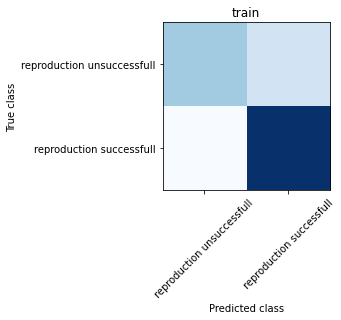

test ################################################################################
Accuracy: 0.6341463414634146
Precision: 0.6844262295081968
Recall: 0.6549019607843137



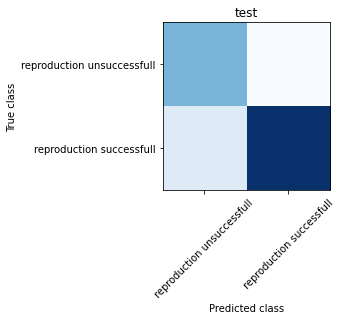

In [9]:
evaluate_model(lr_model, lr_extract_inputs, lr_extract_outputs)

In [10]:
lr_model.steps

[('scaler', StandardScaler()), ('classifier', LogisticRegression())]

In [11]:
clf = lr_model.steps[1][1]
clf.coef_

array([[-0.15664566,  0.14243029,  0.234515  , -0.25802273,  0.37882899,
         0.04837266, -0.01932879,  0.06977899,  0.16198702, -0.19919018,
        -0.46624661, -0.01944348,  0.41021434]])

In [12]:
for col_name, weight in zip(LR_INPUT_COLUMNS, clf.coef_[0]):
    print(col_name, ':', weight)

age : -0.1566456584601627
body_development : 0.14243028744579053
DIB_placement_converted : 0.23451500181640325
season_autumn : -0.25802272900984125
season_winter : 0.37882898523290975
season_spring : 0.04837266112334211
season_summer : -0.01932879055859706
success_insemination_count : 0.06977899189121947
success_natural_count : 0.16198702068556073
fail_insemination_count : -0.19919017915443823
fail_natural_count : -0.4662466096989893
pregnant_after_count : -0.01944348157909861
empty_after_count : 0.41021434095762616


### Conclusión
En este modelo, utilizando las métricas mencionadas anteriormente, obtuvimos un 65% en Accuracy y un 72% en Recall en la validación. Aunque el Accuracy no es muy alto, lo vemos aceptable; ya que encontramos más de la mitad de los casos

## Segundo modelo: K nearest neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
K = 100

knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

In [15]:
knn_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=100))])

train ################################################################################
Accuracy: 0.6476683937823834
Precision: 0.6468716861081655
Recall: 0.8100929614873837



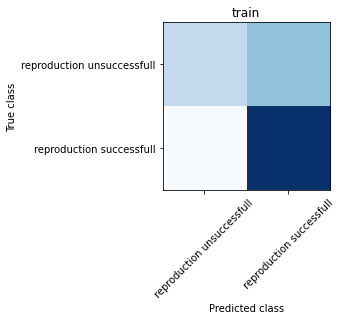

test ################################################################################
Accuracy: 0.647450110864745
Precision: 0.6558441558441559
Recall: 0.792156862745098



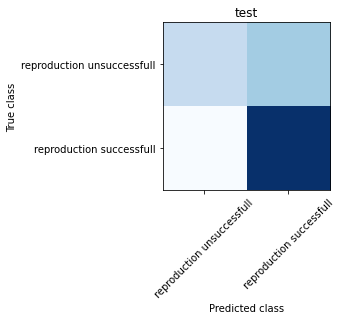

In [16]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs)

### Conclusión
Al diferencia del modelo anterior, obtuvimos en validación un 60% en Accuracy (%3 menos), un poco menor, y un 80% en Recall (%4 más).

Podemos obervar también que los resultados de la validación son casi identicos a los del entrenamiento, lo que nos da indicios de que el modelo se comporta de la misma forma con datos nuevos.

## Tercer modelo: Decision Trees

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
# final input columns, in the order we want to use them
TREE_INPUT_COLUMNS = [
    'age',
    'body_development',
    'DIB_placement_converted',
    'season',
    #'success_reproduction_count',
    'success_insemination_count',
    'success_natural_count',
    #'fail_reproduction_count',
    'fail_insemination_count',
    'fail_natural_count',
    'pregnant_after_count',
    'empty_after_count',
]


def tree_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # season to labels
    inputs['season'] = inputs.season.map({'autumn': 1, 'winter': 2, 'spring': 3, 'summer': 4})

    # return the raw numbers
    return inputs[TREE_INPUT_COLUMNS].values

def tree_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.transformed_reproduction_released.values

In [19]:
tree_model = DecisionTreeClassifier(max_depth=6)

In [20]:
tree_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

DecisionTreeClassifier(max_depth=6)

train ################################################################################
Accuracy: 0.6817172464840858
Precision: 0.6845714285714286
Recall: 0.795484727755644



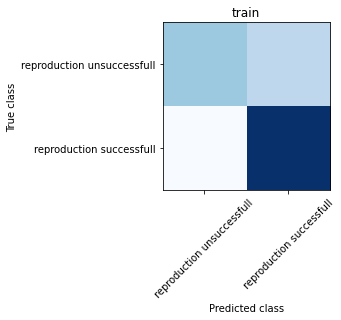

test ################################################################################
Accuracy: 0.6541019955654102
Precision: 0.6774193548387096
Recall: 0.7411764705882353



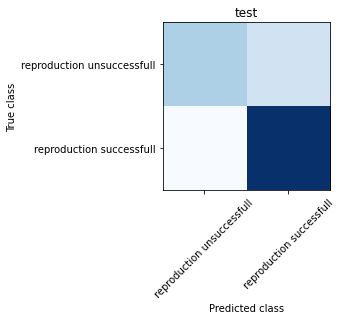

In [21]:
evaluate_model(tree_model, tree_extract_inputs, tree_extract_outputs)

#### Conclusión
En este modelo podemos observar que obtuvimos resultados mejores que con los dos anteriores. Podemos agrear que son más fáciles de sobrenrenar que la regresión lineal y el K-NN, ya que tuvimos que configurarlo con una profundidad máxima de 6 niveles porque arrojaba resultados por encima del 99% en el train y en el validation solo llegabamos al 60 %

## Cuarto modelo: Random Forests

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
forest_model = RandomForestClassifier(max_depth=6)
# n_estimators? max_depth=3?, max_features=2?

In [24]:
forest_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

RandomForestClassifier(max_depth=6)

train ################################################################################
Accuracy: 0.7150259067357513
Precision: 0.6932773109243697
Recall: 0.8764940239043825



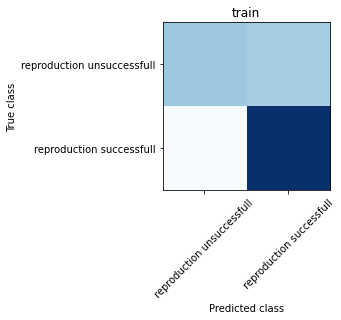

test ################################################################################
Accuracy: 0.6873614190687362
Precision: 0.6838709677419355
Recall: 0.8313725490196079



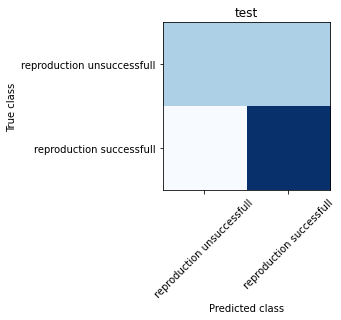

In [25]:
evaluate_model(forest_model, tree_extract_inputs, tree_extract_outputs)

#### Conclusión
Al igual que en el modelo anterior, obtuvimos resultados de Accuracy mejores que con la regresión lineal y el K-NN. Con resultados del 70% con Accuracy y 81 % con Recall concluimos que este modelo es menos conveniente que los anteriores.

## Fifth model: Gradient Boosted Trees

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

In [27]:
boost_model = GradientBoostingClassifier()

In [28]:
boost_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

GradientBoostingClassifier()

train ################################################################################
Accuracy: 0.7194670614359734
Precision: 0.7101123595505618
Recall: 0.8393094289508632



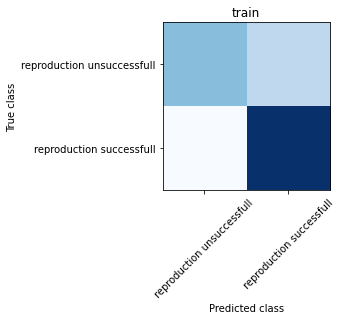

test ################################################################################
Accuracy: 0.6940133037694013
Precision: 0.6983050847457627
Recall: 0.807843137254902



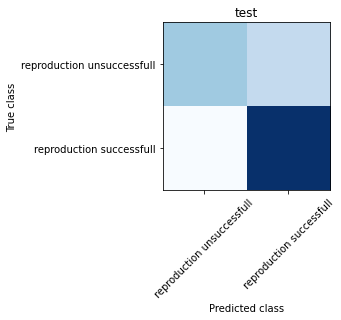

In [29]:
evaluate_model(boost_model, tree_extract_inputs, tree_extract_outputs)

#### Conclusión
Al igual que en el modelo anterior, obtuvimos resultados de Accuracy mejores que con la regresión lineal y el K-NN. Con resultados del 71% con Accuracy y 84 % con Recall concluimos que este modelo es menos conveniente que los anteriores.

## Sexto modelo: Neural Networks

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

In [31]:
nn_model = Sequential([   
    Dense(50, input_shape=(len(LR_INPUT_COLUMNS), )),
    Activation('tanh'),
    
    # Dropout(0.1),

    Dense(50),
    Activation('tanh'),
    
    # Dropout(0.1),

    Dense(1),
    Activation('sigmoid'),
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [32]:
history = nn_model.fit(
    lr_extract_inputs(train), 
    lr_extract_outputs(train),
    epochs=500,
    batch_size=128,
    validation_data=(
        lr_extract_inputs(test),
        lr_extract_outputs(test),
    )
)

Epoch 1/500
11/11 [==============================] - 0s 14ms/step - loss: 0.7063 - accuracy: 0.5270 - val_loss: 0.6902 - val_accuracy: 0.5654
Epoch 2/500
11/11 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.5514 - val_loss: 0.6822 - val_accuracy: 0.5831
Epoch 3/500
11/11 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.5744 - val_loss: 0.6749 - val_accuracy: 0.5632
Epoch 4/500
11/11 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.5603 - val_loss: 0.6737 - val_accuracy: 0.5654
Epoch 5/500
11/11 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.5766 - val_loss: 0.6657 - val_accuracy: 0.5765
Epoch 6/500
11/11 [==============================] - 0s 4ms/step - loss: 0.6671 - accuracy: 0.5855 - val_loss: 0.6601 - val_accuracy: 0.6075
Epoch 7/500
11/11 [==============================] - 0s 4ms/step - loss: 0.6631 - accuracy: 0.6055 - val_loss: 0.6553 - val_accuracy: 0.5898
Epoch 8/500


Epoch 59/500
11/11 [==============================] - 0s 4ms/step - loss: 0.6088 - accuracy: 0.6788 - val_loss: 0.6240 - val_accuracy: 0.6497
Epoch 60/500
11/11 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6691 - val_loss: 0.6258 - val_accuracy: 0.6674
Epoch 61/500
11/11 [==============================] - 0s 2ms/step - loss: 0.6074 - accuracy: 0.6854 - val_loss: 0.6510 - val_accuracy: 0.6231
Epoch 62/500
11/11 [==============================] - 0s 4ms/step - loss: 0.6083 - accuracy: 0.6743 - val_loss: 0.6210 - val_accuracy: 0.6696
Epoch 63/500
11/11 [==============================] - 0s 3ms/step - loss: 0.6056 - accuracy: 0.6788 - val_loss: 0.6268 - val_accuracy: 0.6497
Epoch 64/500
11/11 [==============================] - 0s 3ms/step - loss: 0.6035 - accuracy: 0.6839 - val_loss: 0.6235 - val_accuracy: 0.6475
Epoch 65/500
11/11 [==============================] - 0s 3ms/step - loss: 0.6028 - accuracy: 0.6891 - val_loss: 0.6293 - val_accuracy: 0.6408
Epoch 

11/11 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0.78 - 0s 4ms/step - loss: 0.5743 - accuracy: 0.6995 - val_loss: 0.6171 - val_accuracy: 0.6386
Epoch 117/500
11/11 [==============================] - 0s 4ms/step - loss: 0.5746 - accuracy: 0.6913 - val_loss: 0.6184 - val_accuracy: 0.6475
Epoch 118/500
11/11 [==============================] - 0s 4ms/step - loss: 0.5733 - accuracy: 0.6913 - val_loss: 0.6173 - val_accuracy: 0.6475
Epoch 119/500
11/11 [==============================] - 0s 4ms/step - loss: 0.5728 - accuracy: 0.6928 - val_loss: 0.6178 - val_accuracy: 0.6475
Epoch 120/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5728 - accuracy: 0.6958 - val_loss: 0.6200 - val_accuracy: 0.6408
Epoch 121/500
11/11 [==============================] - 0s 4ms/step - loss: 0.5774 - accuracy: 0.7024 - val_loss: 0.6160 - val_accuracy: 0.6630
Epoch 122/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5751 - accuracy: 0.6906 - val_loss: 0

11/11 [==============================] - 0s 3ms/step - loss: 0.5643 - accuracy: 0.7039 - val_loss: 0.6161 - val_accuracy: 0.6430
Epoch 174/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5542 - accuracy: 0.7084 - val_loss: 0.6242 - val_accuracy: 0.6319
Epoch 175/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5439 - accuracy: 0.7172 - val_loss: 0.6232 - val_accuracy: 0.6341
Epoch 176/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5447 - accuracy: 0.7209 - val_loss: 0.6203 - val_accuracy: 0.6386
Epoch 177/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5423 - accuracy: 0.7158 - val_loss: 0.6186 - val_accuracy: 0.6364
Epoch 178/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5423 - accuracy: 0.7135 - val_loss: 0.6276 - val_accuracy: 0.6297
Epoch 179/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5432 - accuracy: 0.7202 - val_loss: 0.6248 - val_accuracy: 0.6319
Epoch 180/500

11/11 [==============================] - 0s 3ms/step - loss: 0.5188 - accuracy: 0.7343 - val_loss: 0.6250 - val_accuracy: 0.6452
Epoch 231/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5170 - accuracy: 0.7387 - val_loss: 0.6272 - val_accuracy: 0.6541
Epoch 232/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5159 - accuracy: 0.7417 - val_loss: 0.6231 - val_accuracy: 0.6452
Epoch 233/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5139 - accuracy: 0.7409 - val_loss: 0.6232 - val_accuracy: 0.6475
Epoch 234/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5131 - accuracy: 0.7358 - val_loss: 0.6289 - val_accuracy: 0.6364
Epoch 235/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5125 - accuracy: 0.7387 - val_loss: 0.6196 - val_accuracy: 0.6497
Epoch 236/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5127 - accuracy: 0.7402 - val_loss: 0.6349 - val_accuracy: 0.6231
Epoch 237/500

11/11 [==============================] - 0s 3ms/step - loss: 0.5119 - accuracy: 0.7365 - val_loss: 0.6335 - val_accuracy: 0.6430
Epoch 288/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4970 - accuracy: 0.7594 - val_loss: 0.6369 - val_accuracy: 0.6319
Epoch 289/500
11/11 [==============================] - 0s 2ms/step - loss: 0.4868 - accuracy: 0.7476 - val_loss: 0.6303 - val_accuracy: 0.6408
Epoch 290/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4901 - accuracy: 0.7557 - val_loss: 0.6401 - val_accuracy: 0.6519
Epoch 291/500
11/11 [==============================] - 0s 2ms/step - loss: 0.4954 - accuracy: 0.7439 - val_loss: 0.6312 - val_accuracy: 0.6386
Epoch 292/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4873 - accuracy: 0.7572 - val_loss: 0.6355 - val_accuracy: 0.6408
Epoch 293/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4849 - accuracy: 0.7602 - val_loss: 0.6289 - val_accuracy: 0.6475
Epoch 294/500

11/11 [==============================] - 0s 3ms/step - loss: 0.4726 - accuracy: 0.7631 - val_loss: 0.6530 - val_accuracy: 0.6563
Epoch 345/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4765 - accuracy: 0.7580 - val_loss: 0.6531 - val_accuracy: 0.6563
Epoch 346/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4760 - accuracy: 0.7528 - val_loss: 0.6415 - val_accuracy: 0.6497
Epoch 347/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4714 - accuracy: 0.7535 - val_loss: 0.6445 - val_accuracy: 0.6408
Epoch 348/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4701 - accuracy: 0.7698 - val_loss: 0.6459 - val_accuracy: 0.6430
Epoch 349/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4693 - accuracy: 0.7676 - val_loss: 0.6583 - val_accuracy: 0.6608
Epoch 350/500
11/11 [==============================] - 0s 4ms/step - loss: 0.4758 - accuracy: 0.7594 - val_loss: 0.6470 - val_accuracy: 0.6408
Epoch 351/500

11/11 [==============================] - 0s 3ms/step - loss: 0.4541 - accuracy: 0.7698 - val_loss: 0.6569 - val_accuracy: 0.6430
Epoch 402/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4542 - accuracy: 0.7720 - val_loss: 0.6558 - val_accuracy: 0.6475
Epoch 403/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4544 - accuracy: 0.7742 - val_loss: 0.6566 - val_accuracy: 0.6452
Epoch 404/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4640 - accuracy: 0.7646 - val_loss: 0.6627 - val_accuracy: 0.6452
Epoch 405/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4522 - accuracy: 0.7705 - val_loss: 0.6627 - val_accuracy: 0.6386
Epoch 406/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4522 - accuracy: 0.7779 - val_loss: 0.6701 - val_accuracy: 0.6497
Epoch 407/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4537 - accuracy: 0.7772 - val_loss: 0.6590 - val_accuracy: 0.6519
Epoch 408/500

11/11 [==============================] - 0s 3ms/step - loss: 0.4393 - accuracy: 0.7779 - val_loss: 0.6793 - val_accuracy: 0.6430
Epoch 459/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4450 - accuracy: 0.7639 - val_loss: 0.6707 - val_accuracy: 0.6475
Epoch 460/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4405 - accuracy: 0.7809 - val_loss: 0.6892 - val_accuracy: 0.6563
Epoch 461/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4558 - accuracy: 0.7646 - val_loss: 0.6853 - val_accuracy: 0.6585
Epoch 462/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4547 - accuracy: 0.7750 - val_loss: 0.6830 - val_accuracy: 0.6608
Epoch 463/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4479 - accuracy: 0.7676 - val_loss: 0.6739 - val_accuracy: 0.6541
Epoch 464/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4375 - accuracy: 0.7720 - val_loss: 0.6743 - val_accuracy: 0.6364
Epoch 465/500

train ################################################################################
Accuracy: 0.6476683937823834
Precision: 0.6468716861081655
Recall: 0.8100929614873837



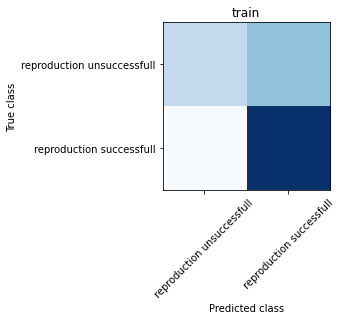

test ################################################################################
Accuracy: 0.647450110864745
Precision: 0.6558441558441559
Recall: 0.792156862745098



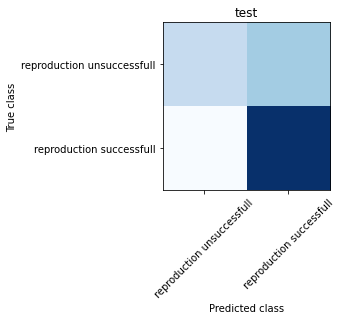

validation ################################################################################
Accuracy: 0.6488888888888888
Precision: 0.6378205128205128
Recall: 0.8155737704918032



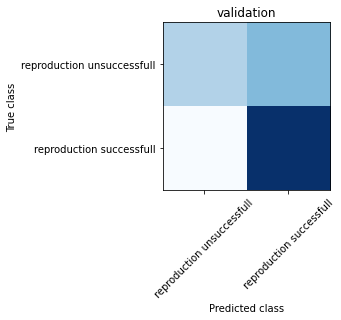

In [33]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs, True)

#### Conclusión
Luego de varias iteraciones sobre diferentes modelos de NN, no logramos mejorar los resultados obtenidos a traves de otros modelos. Probablemente se pueda mejorar un poco los resultados con las funciones de activacion y las cantidades de neuronas por capa correctas, pero teniendo en cuenta que los resultados de todos los modelos no tenían un Accuracy prometedor, se sospecha que puede deberse al dataset utilizado, cuyos datos no provean suficiente informacion para lograr mejores predicciones.

### Conclusión final
El mejor resultado obtenido fue mediante **Gradient Boosted Trees**:

train ################################################################################
Accuracy: 0.7194670614359734
Precision: 0.7101123595505618
Recall: 0.8393094289508632



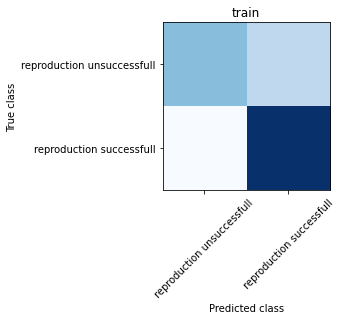

test ################################################################################
Accuracy: 0.6940133037694013
Precision: 0.6983050847457627
Recall: 0.807843137254902



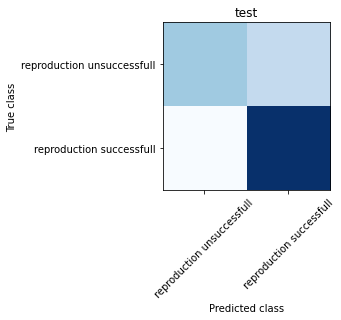

validation ################################################################################
Accuracy: 0.6666666666666666
Precision: 0.6631944444444444
Recall: 0.7827868852459017



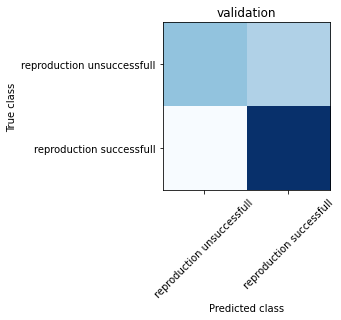

In [34]:
evaluate_model(boost_model, tree_extract_inputs, tree_extract_outputs, True) #con validation